# CartPole-PPO implementation

PPO test in the CartPole environment

In [1]:
import gym
import numpy as np
import tensorflow as tf 
from tensorflow import keras
from collections import deque
import random
from matplotlib import pyplot as plt

env = gym.make('CartPole-v1')

## Memory

Class used to memorize the trajectory and calculate the advantage

In [2]:
class Memory(object):
    
    STATE = 0
    ACTION = 1
    ACTION_PROB = 2
    REWARD = 3
    DONE = 4
    
    def __init__(self, n_trajectories, gamma = 0.95, lambda_p = 0.99, discount_rate = 0.95):
        self.trajectories = np.empty(n_trajectories, dtype=object)
        self.rnd_indices = None
        self.n_trajectories = n_trajectories
        self.gamma = gamma
        self.lambda_p = lambda_p
        self.discount_rate = discount_rate
        
        self.last_pos = 0
        
        self.advantages = []
        self.TDresiduals = [] #list of all the delta, used to update the critic
        self.discounts = []
        
        
    def collect(self, state, action, action_prob, reward, done, i_episode):
        if (self.trajectories[i_episode] == None):
            self.trajectories[i_episode] = deque(maxlen=N_STEPS)
        self.trajectories[i_episode].append((state, action, action_prob, reward, done))
    
    def calculate_advantages(self):

        for trajectory in self.trajectories:
            
            advantage_trajectory = [] #list of advantages for each element in a single trajectory
            delta = []
            G = []
            
            old_v_t = ppo.return_v_values(trajectory[-1][self.STATE])[0]
            advantage = 0
            discount = 0
            
            for i in range(len(trajectory)-2,-1,-1):
                v_t =  ppo.return_v_values(trajectory[i][self.STATE])[0]
                
                delta.append(trajectory[i+1][self.REWARD] + 
                             self.gamma*old_v_t - v_t)
                discount = trajectory[i+1][self.REWARD] + self.discount_rate*discount
                advantage = delta[-1] + self.gamma*self.lambda_p*advantage
                
                G.append(discount)
                advantage_trajectory.append(advantage)   
                
                old_v_t = v_t
            
            self.advantages.append(advantage_trajectory)
            self.TDresiduals.append(delta)
            self.discounts.append(G)
        
        
    #pick a random batch example from the trajectories, add respective advantage, TDerror and G
    def sample_experiences(self, batch_size):
            
        if (self.rnd_indices == None):
            self.rnd_indices = [(i,j) for i in range(self.n_trajectories) for j in range(len(self.trajectories[i])-1) ]
            random.shuffle(self.rnd_indices)
        
        if (self.last_pos + batch_size < len(self.rnd_indices)):
            indices = self.rnd_indices[self.last_pos:self.last_pos + batch_size]
            self.last_pos = self.last_pos + batch_size
        else:
            indices = self.rnd_indices[self.last_pos:]
            self.last_pos = 0
            self.rnd_indices = None
        
        batch = [(self.trajectories[i][j][self.STATE],
                  self.trajectories[i][j][self.ACTION], 
                  self.trajectories[i][j][self.ACTION_PROB], 
                  self.trajectories[i][j][self.REWARD], 
                  self.advantages[i][len(self.trajectories[i]) - 2 - j],
                  self.TDresiduals[i][len(self.trajectories[i]) - 2 - j],
                  self.discounts[i][len(self.trajectories[i]) - 2 - j],
                  self.trajectories[i][j][self.DONE], 
                 ) 
                 for i,j in indices]
        
        states, actions, actions_prob, rewards, advantages, TDresiduals, discounts, dones = [np.array([experience[field_index] for experience in batch]) for field_index in range(8)]
        return states, actions, actions_prob, rewards, advantages, TDresiduals, discounts, dones
    
    
    def reset(self):
        for trajectory in self.trajectories:
            trajectory.clear()
            
        self.rnd_indices = None
        
        self.advantages.clear()
        self.TDresiduals.clear()
        self.discounts.clear()
        self.last_pos = 0

# PPO class

$ s_{t+1} $ and $ r_{t+1} $ are the observed state/reward after the current action $ a_t $.
$ a_{T-1} $ is the last action taken and $ s_T $, $ r_T $ are the last observation/reward.

Actor parameter updated to maximize:
$  L^{CLIP}(\theta) = \hat{\mathbb{E}}_t[min(r_t(\theta)\hat{A}_t, clip(r_t(\theta), 1-\epsilon, 1+\epsilon)\hat{A}_t) + \beta H_t ] $

Critic parameter update to minimize:
$ L(w) = \sum(\hat{v}(s_t,w) - G_t)^2$

Probability ratio $ r_t(\theta) \doteq $
$ \pi_\theta(a_t | s_t) \over \pi_{\theta_old}(a_t | s_t) $

Advantage:
$ \hat{A}_t \doteq \delta_t + (\gamma\lambda)\delta_{t+1} + (\gamma\lambda)^2\delta_{t+2} + ... + (\gamma\lambda)^{T
-t-1}\delta_{T-1} = \delta_t + (\gamma\lambda)\hat{A}_{t+1}$

TD residual:
$ \quad \delta_t  \doteq $
$ r_{t+1} + \gamma\hat{v}(s_{t+1},w) - \hat{v}(s_t,w) $ $ \qquad $

Discount return:
$ G_t \doteq $
$ r_{t+1} + \gamma r_{t+2} + \gamma^2 r_{t+3} + ... + \gamma^{T-t+1} r_{T-t-1} = r_{t+1} + \gamma G_{t+1} $

Entropy:
$ H_t \doteq $
$ - \sum \pi(a_t|s_t,\theta)log_2(\pi_{\theta}(a_t|s_t)) $

In [5]:
class PPO(object):
    
    input_shape = [4]
    n_outputs = env.action_space.n # 2 actions
    
    next_reward = 0
    
    def __init__(self, n_episodes = 1, train_steps = 100, epsilon = 0.1, alpha = 1, beta = 0.9):
        self.actor = self.create_actor()
        self.actor_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
        
        self.critic = self.create_critic()
        self.critic_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
        
        self.epsilon = epsilon
        self.alpha = alpha
        self.beta = beta
        
        self.train_steps = train_steps
        
        self.memory = Memory(n_episodes)
        
    #create the NN of the actor
    # Given the state returns the probability of each action
    def create_actor(self):    
        initializer = tf.keras.initializers.GlorotNormal()
        actor = keras.Sequential([
            keras.layers.Dense(32, activation="tanh", input_shape=self.input_shape, kernel_initializer=initializer),
            keras.layers.Dense(32, activation="tanh", kernel_initializer=initializer),
            keras.layers.Dense(self.n_outputs, kernel_initializer=initializer, activation = 'softmax') ])
        
        return actor
       
    #create the NN of the critic
    # Given the state returns the value function
    def create_critic(self):
        critic = keras.Sequential([
            keras.layers.Dense(32, activation="relu", input_shape=self.input_shape),
            keras.layers.Dense(32, activation="relu"),
            keras.layers.Dense(1) ])
        
        self.critic_loss_fn = tf.keras.losses.mean_squared_error
        
        return critic
      
    def play_one_step(self, env, observation, i_episode):
        action, action_prob = self.select_action(observation)
        past_reward = self.next_reward
        next_observation, self.next_reward, done, info = env.step(action)
        self.memory.collect(observation, action, action_prob, past_reward, done, i_episode)
        if (done):
            self.memory.collect(next_observation, action, action_prob, self.next_reward, done, i_episode)
            
        return next_observation, action, past_reward, done, info
        
    def select_action(self, observation):
        
        action_probabilities = self.actor.predict(np.array([observation,]))[0]
        action = np.random.choice(a = len(action_probabilities), p = action_probabilities)
        return action, action_probabilities[action]
    
    def train(self, batch_size):
        self.memory.calculate_advantages()
        
        for i_step in range(self.train_steps):
            self.training_step(batch_size)
        
        self.memory.reset()
        
    #training done on the memory (the advantages must be calculated beforehand)
    def training_step(self, batch_size):
        #get experiences (random samples of the trajectories) from the memory
        experiences = self.memory.sample_experiences(batch_size)
        states, actions, actions_prob, rewards, advantages, TDresiduals, discounts, dones = experiences
            
        #Actor update
        
        mask = tf.one_hot(actions, self.n_outputs)
        
        with tf.GradientTape() as tape:
            current_actions_prob = self.actor(states)
            
            masked_action_prob = tf.reduce_sum(current_actions_prob*mask, axis=1, keepdims=True)
            old_actions_prob = tf.reshape(tf.convert_to_tensor(actions_prob), [len(states), 1])
            probability_ratio = tf.math.exp(tf.math.subtract(tf.math.log(masked_action_prob + 1e-7), tf.math.log(old_actions_prob + 1e-7)))
            
            #sobtitute nan values with zero (where given an array of True/false put the element of the first array (tf.zeros_like(probability_ratio)) in the position where is True, the second (probability_ratio) where is False)
            #probability_ratio = tf.where(tf.math.is_nan(probability_ratio), tf.zeros_like(probability_ratio), probability_ratio)
            
            surrogate_arg_1 = tf.math.multiply(probability_ratio, advantages)
            surrogate_arg_2 = tf.math.multiply(tf.keras.backend.clip(probability_ratio, 1-self.epsilon*self.alpha, 1+self.epsilon*self.alpha), advantages)
            
            entropy = - self.beta*tf.reduce_sum(current_actions_prob*(tf.math.log(current_actions_prob + 1e-7)/tf.math.log(2.)), 1, keepdims=True )
            
            L = - tf.minimum( surrogate_arg_1 , surrogate_arg_2 ) - entropy
            
            loss = tf.reduce_mean(L)

        actor_weights = self.actor.trainable_variables
        grads = tape.gradient(loss, actor_weights)
        self.actor_optimizer.apply_gradients(zip(grads, actor_weights))
        
        # Critic update. 
        target_v_values = tf.reshape(tf.convert_to_tensor(np.asarray(discounts).astype('float32')), (len(states), 1))
        
        with tf.GradientTape() as tape:
            v_values = self.critic(states)
            loss = tf.reduce_sum(tf.math.square(tf.math.subtract(v_values, target_v_values)))
        grads = tape.gradient(loss, self.critic.trainable_variables)
        self.critic_optimizer.apply_gradients(zip(grads, self.critic.trainable_variables))
    
    def return_v_values(self, observation):
        v = self.critic.predict(np.array( [observation,]))[0]
        return v
    
    def update_hyperparam(self):
        self.alpha = self.alpha - 0.1/N_EPOCHS
        self.actor_optimizer.lr.assign(1e-4 * self.alpha)

## Training

In [6]:
N_EPOCHS = 135
N_EPISODES = 5 # number of trajectories collected in one epoch
N_STEPS = 300 # max number of step for each episode

TRAIN_STEPS = 300 # number of max steps done during training.
BATCH_SIZE = 32

ppo = PPO(n_episodes = N_EPISODES, train_steps = TRAIN_STEPS, beta = 1e-3)

rewards = []


for i_epoch in range(N_EPOCHS):
    
    epoch_reward = 0.0
    
    for i_episode in range(N_EPISODES):
        
        observation = env.reset()
        
        episode_reward = 0.0
        
        for i_step in range(N_STEPS):   
            
            observation, action, reward, done, info = ppo.play_one_step(env, observation, i_episode)

            episode_reward = episode_reward + reward

            if(done or i_step == N_STEPS-1):
                epoch_reward = epoch_reward + episode_reward
                break
    
    print("Epoch {} terminated with average reward {}".format(i_epoch, epoch_reward/N_EPISODES))
    rewards.append(epoch_reward/N_EPISODES)
    
    ppo.train(batch_size = BATCH_SIZE)
    ppo.update_hyperparam()
        
env.close()

Epoch 0 terminated with average reward 25.0
Epoch 1 terminated with average reward 26.4
Epoch 2 terminated with average reward 23.8
Epoch 3 terminated with average reward 23.2
Epoch 4 terminated with average reward 22.8
Epoch 5 terminated with average reward 20.0
Epoch 6 terminated with average reward 23.6
Epoch 7 terminated with average reward 24.0
Epoch 8 terminated with average reward 22.4
Epoch 9 terminated with average reward 22.4
Epoch 10 terminated with average reward 22.2
Epoch 11 terminated with average reward 34.8
Epoch 12 terminated with average reward 36.0
Epoch 13 terminated with average reward 25.4
Epoch 14 terminated with average reward 20.2
Epoch 15 terminated with average reward 41.8
Epoch 16 terminated with average reward 40.2
Epoch 17 terminated with average reward 83.6
Epoch 18 terminated with average reward 41.8
Epoch 19 terminated with average reward 59.4
Epoch 20 terminated with average reward 48.4
Epoch 21 terminated with average reward 39.6
Epoch 22 terminated 

KeyboardInterrupt: 

## Plot graph

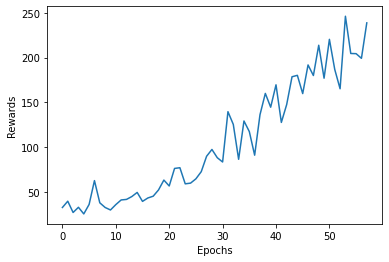

In [6]:
epochs = range(58)

plt.plot(epochs, rewards)

plt.xlabel("Epochs")
plt.ylabel("Rewards")

plt.show()

# Tests

Tests done during development

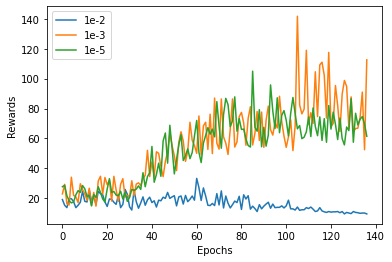

In [25]:
#rewards_test.append(rewards)

epochs = range(137)

plt.plot(epochs, rewards_test[2], label = "1e-2")
plt.plot(epochs, rewards_test[0], label = "1e-3")
#plt.plot(epochs, rewards_test[1], label = "1e-4")
plt.plot(epochs, rewards_test[3], label = "1e-5")

plt.xlabel("Epochs")
plt.ylabel("Rewards")

plt.legend()
plt.show()

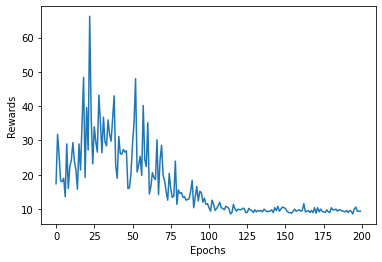

In [5]:
#TEST 2 using discounted return and A_t+1 = TDError + A_t but v is updated on G_t
epochs = range(N_EPOCHS)

plt.plot(epochs, rewards)

plt.xlabel("Epochs")
plt.ylabel("Rewards")

plt.show()

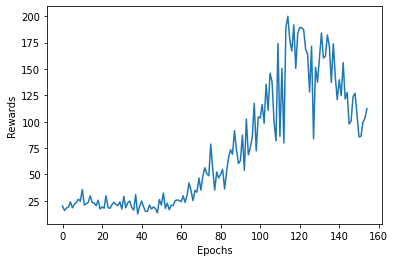

In [5]:
#TEST 4 using discounted return and A_t+1 = TDError + A_t but v is updated on G_t using log of the probabilities
epochs = range(155)

plt.plot(epochs, rewards)

plt.xlabel("Epochs")
plt.ylabel("Rewards")

plt.show()